In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)

import os

In [ ]:
base_dir = "../"
outputs_dir = os.path.join(base_dir, "outputs")
models_dir = os.path.join(outputs_dir, "models")
results_dir = os.path.join(outputs_dir, "results")
preprocessed_dir = os.path.join(outputs_dir, "preprocessed")

os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Load from pickle (faster)
X_train = joblib.load(os.path.join(preprocessed_dir, "X_train.pkl"))
X_val   = joblib.load(os.path.join(preprocessed_dir, "X_val.pkl"))
X_test  = joblib.load(os.path.join(preprocessed_dir, "X_test.pkl"))
y_train = joblib.load(os.path.join(preprocessed_dir, "y_train.pkl"))
y_val   = joblib.load(os.path.join(preprocessed_dir, "y_val.pkl"))
y_test  = joblib.load(os.path.join(preprocessed_dir, "y_test.pkl"))

print("Data loaded successfully!")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Data loaded successfully!
Train shape: (1944, 14)
Validation shape: (417, 14)
Test shape: (417, 14)


In [7]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    start_pred = time.time()
    y_pred = model.predict(X_val)
    end_pred = time.time()

    metrics = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
        "ROC-AUC": roc_auc_score(y_val, y_pred),
        "Prediction Time (s)": end_pred - start_pred
    }

    print(f"\n{model_name} Evaluation Results:")
    print(pd.DataFrame(metrics, index=[0]))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

    return metrics

In [8]:
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

start_train = time.time()
grid_search.fit(X_train, y_train)
end_train = time.time()

print("\nGrid Search Complete!")
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

best_dt = grid_search.best_estimator_


Fitting 5 folds for each of 90 candidates, totalling 450 fits

Grid Search Complete!
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best CV Score: 0.9002040654069383



Decision Tree Evaluation Results:
   Accuracy  Precision    Recall  F1 Score   ROC-AUC  Prediction Time (s)
0  0.892086   0.950549  0.827751   0.88491  0.892241             0.008008

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       208
           1       0.95      0.83      0.88       209

    accuracy                           0.89       417
   macro avg       0.90      0.89      0.89       417
weighted avg       0.90      0.89      0.89       417



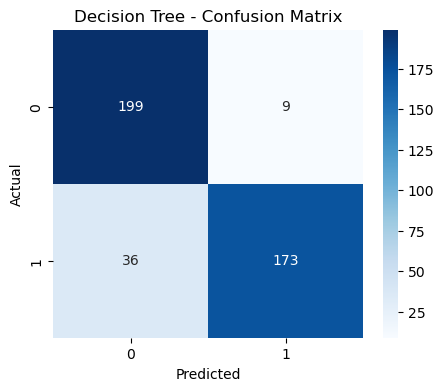

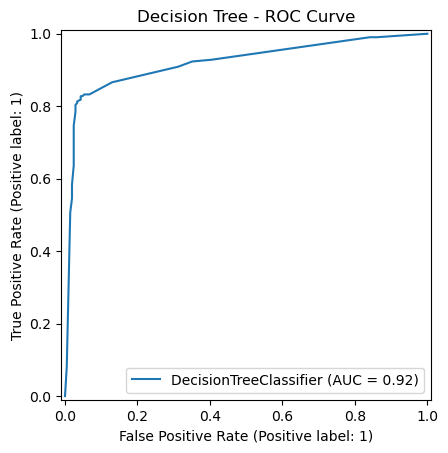

In [9]:
metrics = evaluate_model(best_dt, X_val, y_val, "Decision Tree")

metrics["Training Time (s)"] = end_train - start_train
metrics["Best Params"] = grid_search.best_params_


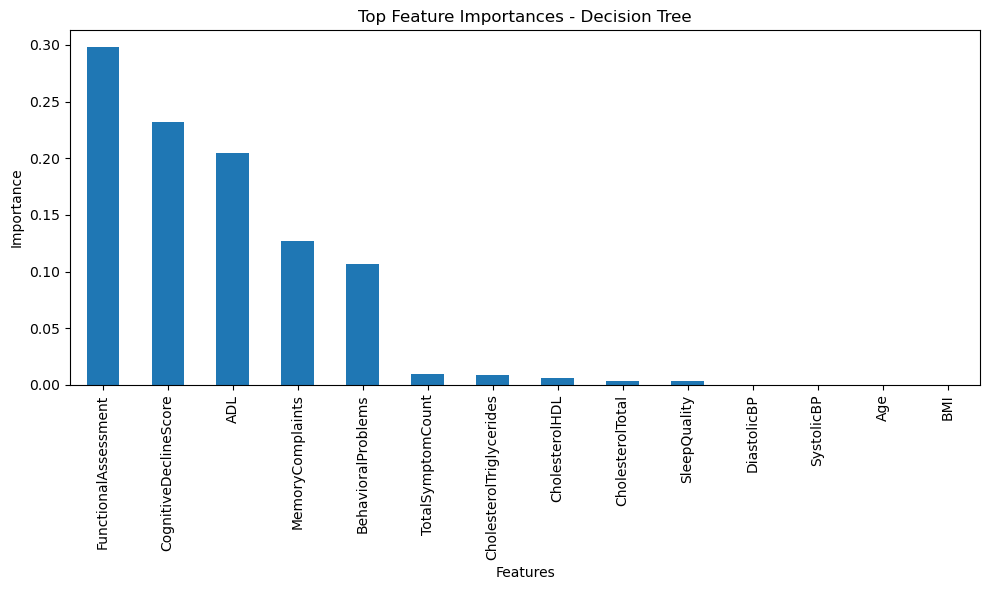

In [10]:
feature_importances = pd.Series(
    best_dt.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.head(20).plot(kind='bar')
plt.title("Top Feature Importances - Decision Tree")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [11]:
outputs_dir = os.path.join(base_dir, "outputs")
models_dir = os.path.join(outputs_dir, "models")
results_dir = os.path.join(outputs_dir, "results")

os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

joblib.dump(best_dt, os.path.join(models_dir, "decision_tree_model.pkl"))
pd.DataFrame([metrics]).to_csv(os.path.join(results_dir, "decision_tree_validation_results.csv"), index=False)
print("\nModel and results saved successfully!")



Model and results saved successfully!


In [12]:
# Predict class labels
model=best_dt
y_pred = model.predict(X_test)

# Predict probabilities (optional, useful for ROC/AUC or risk score)
y_proba = model.predict_proba(X_test)[:, 1]

In [13]:
# Combine actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display first 15 comparisons
comparison_df.head(15)

,Actual,Predicted
0,0,0
1,1,1
2,0,1
3,1,1
4,1,1
5,1,0
6,0,0
7,1,1
8,1,1
9,1,1


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8800959232613909
Precision: 0.9388888888888889
Recall: 0.8125
F1 Score: 0.8711340206185567

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       209
           1       0.94      0.81      0.87       208

    accuracy                           0.88       417
   macro avg       0.89      0.88      0.88       417
weighted avg       0.89      0.88      0.88       417



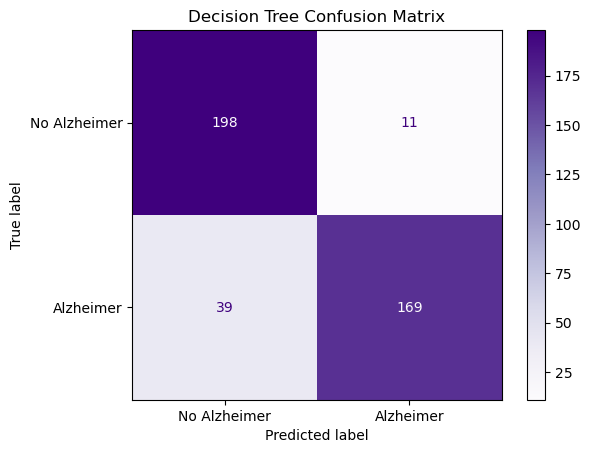

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Alzheimer', 'Alzheimer'])
disp.plot(cmap='Purples', values_format='d')
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [16]:
prob_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Prediction_Probability': y_proba
})

prob_df.head(10)

,Actual,Predicted,Prediction_Probability
0,0,0,0.000000
1,1,1,0.995294
2,0,1,1.000000
3,1,1,0.946429
4,1,1,1.000000
5,1,0,0.213270
6,0,0,0.096154
7,1,1,0.964286
8,1,1,0.995294
9,1,1,0.995294


In [17]:

# Save the comparison DataFrame
comparison_df.to_csv(os.path.join(results_dir, "decision_tree_predictions.csv"), index=False)

print("Saved comparison results to: outputs/results/decision_tree_predictions.csv")


Saved comparison results to: outputs/results/decision_tree_predictions.csv


In [18]:
from sklearn.metrics import roc_auc_score

# Calculate all key metrics
metrics_summary = {
    'Model': ['Decision Tree'],
    'Accuracy': [accuracy_score(y_test, y_pred)],
    'Precision': [precision_score(y_test, y_pred)],
    'Recall': [recall_score(y_test, y_pred)],
    'F1_Score': [f1_score(y_test, y_pred)],
    'ROC_AUC': [roc_auc_score(y_test, y_proba)]
}

metrics_df = pd.DataFrame(metrics_summary)

# Save metrics summary
metrics_df.to_csv(os.path.join(results_dir,'decision_tree_metrics_summary.csv'), index=False)

print("Saved evaluation metrics to: outputs/results/decision_tree_metrics_summary.csv")
metrics_df


Saved evaluation metrics to: outputs/results/decision_tree_metrics_summary.csv


,Model,Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,Decision Tree,0.880096,0.938889,0.8125,0.871134,0.911943
